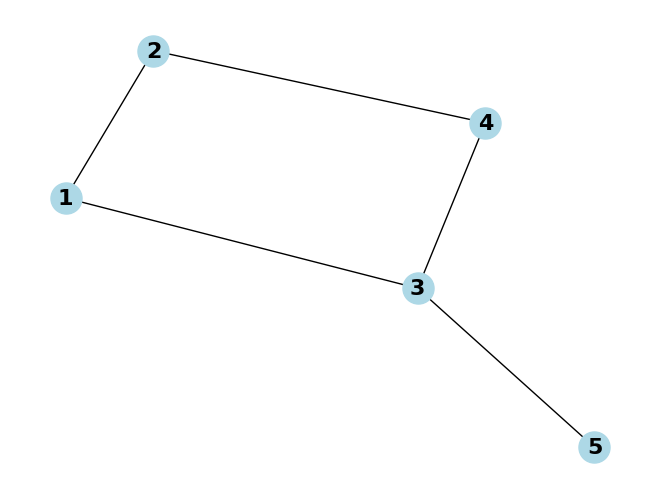

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
nodes = [1, 2, 3, 4, 5]
G.add_nodes_from(nodes)

# Add edges to the graph
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (3, 5)]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=16, font_weight='bold')

# Show the graph
plt.axis('off')
plt.show()

In [ ]:
import gym
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class GraphEnv(gym.Env):
    def __init__(self, graph):
        self.graph = graph
        self.nodes = list(graph.nodes())
        self.num_nodes = len(self.nodes)
        self.observation_space = gym.spaces.Discrete(self.num_nodes)
        self.action_space = gym.spaces.Discrete(self.num_nodes)
        self.current_node = None
        self.end_node = None

    def reset(self, start_node=None, end_node=None):
        if start_node is None:
            self.current_node = np.random.choice(self.nodes)
        else:
            self.current_node = start_node
        if end_node is None:
            self.end_node = np.random.choice(self.nodes)
        else:
            self.end_node = end_node
        return np.array([self.current_node])

    def step(self, action):
        if action in self.graph.neighbors(self.current_node):
            self.current_node = action
            if self.current_node == self.end_node:
                reward = 1.0
                done = True
            else:
                reward = 0.0
                done = False
        else:
            reward = -1.0
            done = False
        return np.array([self.current_node]), reward, done, {}

    def render(self, mode='human'):
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_size=500, font_size=16, font_weight='bold')
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[self.current_node], node_color='red', node_size=500)
        plt.axis('off')
        plt.show()

# Create the graph
G = nx.Graph()
nodes = [0, 1, 2, 3, 4]
G.add_nodes_from(nodes)
edges = [(0, 1), (0, 2), (1, 3), (2, 3), (2, 4)]
G.add_edges_from(edges)

# Create the gym environment
env = GraphEnv(G)

# Example usage
start_node = 2
end_node = 1
obs = env.reset(start_node, end_node)
done = False
while not done:
    env.render()

    action = np.random.choice(list(G.neighbors(obs[0])))
    obs, reward, done, _ = env.step(action)
    print(f"Current node: {obs}, Reward: {reward}, Done: {done}")

In [8]:
def generate_expert_trajectories(graph, num_trajectories):
    """
    Generates expert trajectories in a graph.

    Parameters:
    - graph (networkx.Graph): The graph representing the environment.
    - num_trajectories (int): The number of trajectories to generate.

    Returns:
    - expert_trajectories (list): A list of expert trajectories, where each trajectory is a list of (observation, action) tuples.
    """

    expert_trajectories = []
    for _ in range(num_trajectories):
        start_node = np.random.choice(list(graph.nodes()))
        end_node = np.random.choice(list(graph.nodes()))
        while start_node == end_node:
            end_node = np.random.choice(list(graph.nodes()))
        path = nx.shortest_path(graph, source=start_node, target=end_node)
        import pdb; pdb.set_trace()
        trajectory = []
        for i in range(len(path) - 1):
            obs = np.array([path[i]])
            action = path[i + 1]
            trajectory.append((obs, action))
            print(f"Observation: {obs}, Action: {action}")
        expert_trajectories.append(trajectory)
    
    return expert_trajectories

In [10]:
generate_expert_trajectories(G, 5)

> /var/folders/p3/_7x95kts1j3536nntzbxcf_00000gn/T/ipykernel_26836/1067117618.py(21)generate_expert_trajectories()
     19         path = nx.shortest_path(graph, source=start_node, target=end_node)
     20         import pdb; pdb.set_trace()
---> 21         trajectory = []
     22         for i in range(len(path) - 1):
     23             obs = np.array([path[i]])

[4, 2]


In [4]:
env.action_space

Discrete(5)

In [5]:
def render_path(graph, path, pos):
    nx.draw(graph, pos, with_labels=True, node_size=500, font_size=16, font_weight='bold')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.axis('off')
    plt.show()

In [7]:
import numpy as np
import networkx as nx

def compute_state_visitation_freq(graph, policy, num_trajectories, horizon):
    state_visitation_freq = np.zeros(len(graph.nodes()))
    
    for _ in range(num_trajectories):
        state = np.random.choice(list(graph.nodes()))
        for _ in range(horizon):
            action = policy[state]
            if action in graph.neighbors(state):
                state_visitation_freq[state] += 1
                state = action
            else:
                break
    
    state_visitation_freq /= (num_trajectories * horizon)
    return state_visitation_freq

def compute_maximum_entropy_policy(graph, reward_function, temperature):
    policy = {}
    
    for state in graph.nodes():
        neighbors = list(graph.neighbors(state))
        q_values = np.array([reward_function[neighbor] for neighbor in neighbors])
        probabilities = np.exp(q_values / temperature)
        probabilities /= np.sum(probabilities)
        policy[state] = np.random.choice(neighbors, p=probabilities)
    
    return policy

def update_reward_function(expert_state_visitation_freq, learner_state_visitation_freq, reward_function, learning_rate):
    grad = expert_state_visitation_freq - learner_state_visitation_freq
    reward_function += learning_rate * grad
    return reward_function

def maximum_entropy_irl(graph, expert_trajectories, num_iterations, learning_rate, temperature):
    num_states = len(graph.nodes())
    reward_function = np.zeros(num_states)
    
    expert_state_visitation_freq = np.zeros(num_states)
    for trajectory in expert_trajectories:
        for state, _ in trajectory:
            expert_state_visitation_freq[state] += 1
    expert_state_visitation_freq /= len(expert_trajectories)
    
    for _ in range(num_iterations):
        policy = compute_maximum_entropy_policy(graph, reward_function, temperature)
        learner_state_visitation_freq = compute_state_visitation_freq(graph, policy, len(expert_trajectories), len(expert_trajectories[0]))
        reward_function = update_reward_function(expert_state_visitation_freq, learner_state_visitation_freq, reward_function, learning_rate)
    
    return reward_function

# Example usage
num_trajectories = 100
expert_trajectories = generate_expert_trajectories(G, num_trajectories)

num_iterations = 100
learning_rate = 0.1
temperature = 1.0
reward_function = maximum_entropy_irl(G, expert_trajectories, num_iterations, learning_rate, temperature)

Observation: [3], Action: 2
Observation: [4], Action: 2
Observation: [2], Action: 0
Observation: [0], Action: 1
Observation: [0], Action: 2
Observation: [2], Action: 0
Observation: [4], Action: 2
Observation: [2], Action: 3
Observation: [0], Action: 2
Observation: [4], Action: 2
Observation: [0], Action: 1
Observation: [0], Action: 1
Observation: [1], Action: 3
Observation: [4], Action: 2
Observation: [2], Action: 0
Observation: [1], Action: 0
Observation: [0], Action: 2
Observation: [2], Action: 3
Observation: [4], Action: 2
Observation: [2], Action: 0
Observation: [0], Action: 1
Observation: [4], Action: 2
Observation: [1], Action: 0
Observation: [1], Action: 0
Observation: [0], Action: 2
Observation: [2], Action: 4
Observation: [1], Action: 0
Observation: [4], Action: 2
Observation: [2], Action: 3
Observation: [2], Action: 0
Observation: [0], Action: 1
Observation: [4], Action: 2
Observation: [3], Action: 1
Observation: [1], Action: 0
Observation: [1], Action: 0
Observation: [0], Ac

In [ ]:
reward_function

array([2.839, 0.973, 2.381, 0.211, 0.296])